# KNN-CF Recommender Engine
### This notebook contians the recommender engine using the KNN Collaborative Filtering model.

### Preprocessing and preliminary code:

Libraries used in preprocessing and data manipulation:

In [1]:
import numpy as np 
import pandas as pd

# Libraries for Recommendation System
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors


In [2]:
#To set up the engine we will start with the Movielens 100k
movie_100k = pd.read_csv('data\movielens_100k\movies.csv')
rating_100k = pd.read_csv('data\\movielens_100k\\ratings.csv')
print("Original data columns:")
print(movie_100k.columns)
print(rating_100k.columns)

#We create new dataframes only using the columns that are necessary
movies = movie_100k.loc[:,["movieId","title"]]
ratings = rating_100k.loc[:,["userId","movieId","rating"]]

print("\n\n\nTruncated dataframes;")
print(movies.columns)
print(ratings.columns)

#This command creates a dataframe which merges both ratings and movies based on a common column (movieId)
data_100k = pd.merge(movies,ratings)

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Dominic\AppData\Local\Temp\ipykernel_8808\1108140883.py:2: SyntaxWarning: invalid escape sequence '\m'
  movie_100k = pd.read_csv('data\movielens_100k\movies.csv')


Original data columns:
Index(['movieId', 'title', 'genres'], dtype='object')
Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')



Truncated dataframes;
Index(['movieId', 'title'], dtype='object')
Index(['userId', 'movieId', 'rating'], dtype='object')


In [3]:
#This method performs all preprocessing that is required for the data before using the KNN algorithm
#It takes in a dataset in the form of a dataframe, a index_column_name for specifying by which column in the dataframe we filter by value counts, and a threshold which determines the point at which 
#we stop considering the data in the indexed column by how many times they appear in the dataset.
def preprocess(data, index_column_name, threshold):
    
    #filtering out instances which do not appear more than the threshold in the dataframe
    index_counts = data_100k[index_column_name].value_counts().sort_values(ascending=False)
    filtered_counts = index_counts[index_counts >= threshold]
    pre_processed_data = data_100k[data_100k[index_column_name].isin(filtered_counts.index)]
    
    
    
    return pre_processed_data


We will now try to create a matrix which maps all user ratings to all movies (for each movie (row) we will have each user (column) and their ratings)

In [4]:
data_100k_filtered = preprocess(data_100k, 'movieId', 50)
print("Data shape before preprocessing:")
print(data_100k.shape)
print("Data shape after preprocessing:")
print(data_100k_filtered.shape)
print("\n")


user_movie_table = data_100k_filtered.pivot_table(index=["movieId"], columns=["userId"], values="rating").fillna(0)
print("Pivot table visualization:")    
user_movie_table.head(10)

Data shape before preprocessing:
(100836, 4)
Data shape after preprocessing:
(41360, 4)


Pivot table visualization:


userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0
7,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0
11,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,2.5,3.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,3.0,4.0,0.0,0.0,0.0,0.0,4.5,0.0,4.5
17,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0


For the code above I will provide chatGPTs explanation of the methods bc I couldn't explain it better and i dont care to at the moment:

*Here, the pivot_table function is used to reshape the data dataframe. Let's understand the parameters:*

- *index=["title"]: This sets the "title" column as the index of the pivot table. Each unique movie title will become a row in the pivot table.*
- *columns=["userId"]: This sets the "userId" column as the columns of the pivot table. Each unique user ID will become a column in the pivot table.*
- *values="rating": This specifies that the values to be filled in the pivot table come from the "rating" column of the data dataframe.*
- *fillna(0): This fills any missing (NaN) values in the pivot table with 0.*

*As a result, user_movie_table becomes a matrix where rows represent movies, columns represent users, and the cells contain ratings given by users to movies. Any missing ratings are filled with 0, indicating no rating was given.*

### KNN Engine implemented 


Below I use our previous matrix to implement a basic KNN Recommender using the Sklearn NearestNeighbors library implementation. To show an example of the implementation I pick a random user and print the 5 nearest 

In [5]:

query_index = np.random.choice(user_movie_table.shape[0])

k_value = 6

user_movie_table_matrix = csr_matrix(user_movie_table.values)
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(user_movie_table_matrix)
distances, indices = model_knn.kneighbors(user_movie_table.iloc[query_index,:].values.reshape(1,-1), n_neighbors = k_value+1)
indices = indices[0][1:]


print("Random movie: \"" + str(user_movie_table.index[query_index]) + "\"'s closest " + str(k_value) + " neighbors are:")
j = 0
for i, index in enumerate(indices):
    print("\tRecommendation " + str(i + 1) + "\tMovie: " + str(user_movie_table.index[index]) + ", Distance: " + str(distances[0][i]))

Random movie: "3489"'s closest 6 neighbors are:
	Recommendation 1	Movie: 2005, Distance: 1.1102230246251565e-16
	Recommendation 2	Movie: 3253, Distance: 0.46314214418690824
	Recommendation 3	Movie: 2174, Distance: 0.483580601597282
	Recommendation 4	Movie: 2081, Distance: 0.4882745762338069
	Recommendation 5	Movie: 2987, Distance: 0.49749336414445666
	Recommendation 6	Movie: 3033, Distance: 0.4981760744747121


## Visualizations

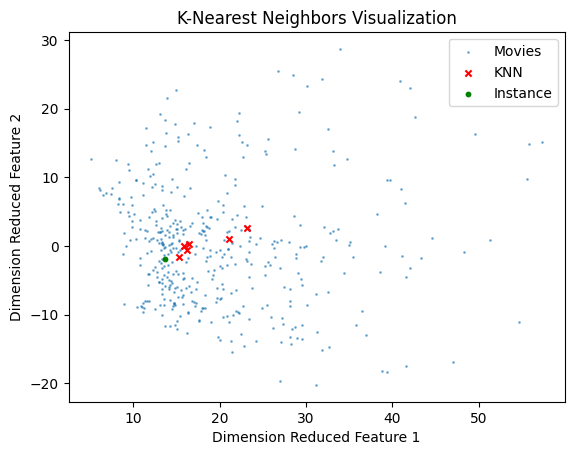

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Assuming user_movie_table_matrix is your sparse user-movie matrix
X = user_movie_table_matrix

# Perform TruncatedSVD to reduce data to 2 dimensions (or any number of dimensions you desire)
svd = TruncatedSVD(n_components=2)
X_reduced = svd.fit_transform(X)

# Plot all data points
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], label='Movies', alpha=0.5, s=1)

# Plot k-nearest neighbors of a specific point (query_index)
plt.scatter(X_reduced[indices, 0], X_reduced[indices, 1], c='red', label='KNN', marker='x', s=20)

plt.scatter(X_reduced[query_index, 0], X_reduced[query_index, 1], c='Green', label='Instance', marker='o', s=10, alpha=1)

plt.legend()
plt.xlabel('Dimension Reduced Feature 1')
plt.ylabel('Dimension Reduced Feature 2')
plt.title('K-Nearest Neighbors Visualization')





plt.show()


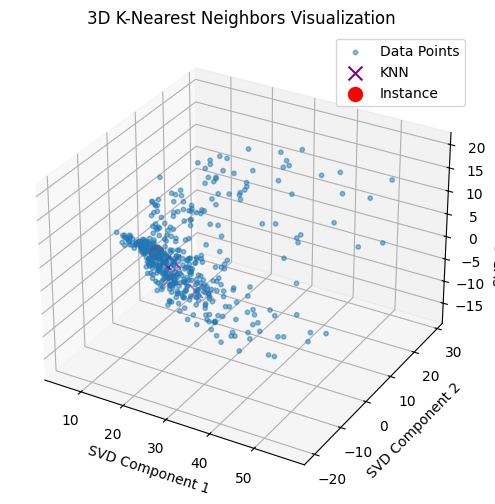

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import TruncatedSVD

# Assuming user_movie_table_matrix is your sparse user-movie matrix
X = user_movie_table_matrix

# Perform TruncatedSVD to reduce data to 3 dimensions
svd = TruncatedSVD(n_components=3)
X_reduced = svd.fit_transform(X)

# Assuming indices are defined (indices of k-nearest neighbors)

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')  # Specify 3D projection

# Plot all data points (set marker size to 50)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], label='Data Points', alpha=0.5, s=10)

# Plot k-nearest neighbors of a specific point (query_index) with a different marker size (e.g., 100)
ax.scatter(X_reduced[indices, 0], X_reduced[indices, 1], X_reduced[indices, 2], c='purple', label='KNN', marker='x', s=100)

ax.scatter(X_reduced[query_index, 0], X_reduced[query_index, 1], X_reduced[query_index, 2], c='red', label='Instance', marker='o', s=100, alpha=1)

ax.set_xlabel('SVD Component 1')
ax.set_ylabel('SVD Component 2')
ax.set_zlabel('SVD Component 3')
ax.set_title('3D K-Nearest Neighbors Visualization')
ax.legend()
# # Set specific limits for each axis to zoom in
# lim = 3
# ax.set_xlim(-lim, lim)  # Specify the minimum and maximum values for the x-axis
# ax.set_ylim(-lim, lim)  # Specify the minimum and maximum values for the y-axis
# ax.set_zlim(-lim, lim)  # Specify the minimum and maximum values for the z-axis


plt.show()


# Evaluation

In [8]:
user_movie_table.head(10)
print(user_movie_table.iloc[indices[1],:])
print(len(user_movie_table.iloc[indices[1],:]))
for index in indices:
    print(index)
    
    

userId
1      5.0
2      0.0
3      0.0
4      0.0
5      0.0
      ... 
606    0.0
607    2.0
608    3.0
609    0.0
610    0.0
Name: 3253, Length: 606, dtype: float64
606
221
288
234
229
279
281


In [9]:
# import random


# def predict_rating_average(pivot_table, indices, distances):
#     averages = []
#     for index in indices:
#         averages.append(pivot_table.iloc[index, :].sum()/len(pivot_table.iloc[index, :]))
#     #print(averages)
#     rating = sum(averages)/len(averages)
#     #print(rating)
#     return rating





# errors = []
# for i in range(0,1):
#     rand_id = np.random.choice(user_movie_table.shape[0])
#     #print(rand_id)
    
#     distances_rand, indices_rand = model_knn.kneighbors(user_movie_table.iloc[rand_id,:].values.reshape(1,-1), n_neighbors = k_value+1)
    
    
#     predicted_rating = predict_rating_average(user_movie_table, indices_rand,distances_rand)
#     #print(predicted_rating)
    
#     #print(user_movie_table.iloc[rand_id,:].sum()/len((user_movie_table.iloc[rand_id,:])))
#     actual_rating = user_movie_table.iloc[rand_id,:].sum()/len((user_movie_table.iloc[rand_id,:]))
    
#     error = abs(actual_rating - predicted_rating)
    
#     errors.append(error)

# average_error = sum(errors)/len(errors)
# print(str(average_error))
    


In [10]:
def predict_user_rating(user_index, movieId, pivot_table, k):
    #Get movie's nearest neighbors
    movieId_index = pivot_table.index.get_loc(movieId)
    
    #print(movieId_index)
    #print(pivot_table.iloc[movieId_index,:])
    p_distances, p_indices  = model_knn.kneighbors(pivot_table.iloc[movieId_index,:].values.reshape(1,-1), n_neighbors = k+1)
    p_indices = p_indices[0][1:]
    
    
    #Get users ratings for those movies
    ratings = []
    
    for index in p_indices:
        #print(pivot_table.iloc[index, user_index])
        ratings.append(pivot_table.iloc[index, user_index-1])
        
        
    #Average their ratings to find their predicted rating for the target movie
    average = sum(ratings)/len(ratings)
    return average






random_movie_id = np.random.choice(user_movie_table.index)
random_user = np.random.choice(user_movie_table.columns)

print("MovieId: ",random_movie_id)
print("Title: ", data_100k_filtered.loc[data_100k_filtered['movieId'] == random_movie_id, 'title'].iloc[0])

print("User: ", random_user)
print("Actual Rating: ", user_movie_table.loc[random_movie_id,random_user])
predicted_rating = predict_user_rating(random_user, random_movie_id, user_movie_table, 10)
print("Predicted Rating: ", predicted_rating)

MovieId:  1732
Title:  Big Lebowski, The (1998)
User:  353
Actual Rating:  0.0
Predicted Rating:  0.0


In [11]:

def create_pivot_table(movies_df, ratings_df):
    data = pd.merge(movies_df,ratings_df)
    return data.pivot_table(index=["movieId"], columns=["userId"], values="rating").fillna(0)

def create_knn(pivot_table):
    new_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
    pivot_matrix = csr_matrix(pivot_table.values) #Required for knn
    new_knn.fit(pivot_matrix)
    return new_knn

#Takes
def predict_user_rating_rafael(userId, movieId, pivot_table, k, knn_model):
    #Get movie's nearest neighbors
    movieId_index = pivot_table.index.get_loc(movieId)
    
    #print(movieId_index)
    #print(pivot_table.iloc[movieId_index,:])
    p_distances, p_indices  = knn_model.kneighbors(pivot_table.iloc[movieId_index,:].values.reshape(1,-1), n_neighbors = k+1)
    p_indices = p_indices[0][1:]
    
    
    #Get users ratings for those movies
    ratings = []
    
    for index in p_indices:
        #print(pivot_table.iloc[index, userId])
        userId_index = pivot_table.columns.get_loc(userId)
        ratings.append(pivot_table.iloc[index, userId_index])
        
        
    #Average their ratings to find their predicted rating for the target movie
    average = sum(ratings)/len(ratings)
    return average

#Steps:
#Initialize pivot_table -> Initialize Knn -> Use prediction Method

In [12]:
p_table = create_pivot_table(movie_100k, rating_100k)
p_table.head(10)

knn2 = create_knn(p_table)
print(predict_user_rating_rafael(1,1,p_table,10,knn2))

3.3


In [17]:


def test_k_accuracy(min_k,max_k, step, iterations, table):
    avg_errors =[]
    for i in range(min_k, max_k, step):
        avg_error = 0
        errors = []
        for j in range(0,iterations):
            random_movie_id = np.random.choice(table.index)
            random_user = np.random.choice(table.columns)

            predicted_rating = predict_user_rating_rafael(random_user,random_movie_id,table,i,test_knn)
            
            actual_rating = user_movie_table.loc[random_movie_id,random_user]
            
            cur_error = abs(predicted_rating-actual_rating)
            errors.append(cur_error)
        avg_error = sum(errors)/len(errors)
        avg_errors.append(avg_error)
        #print("Average error over " + str(iterations) + " iterations for k=" + str(i) + ": " + str(avg_error))
    print("----------------------------------------------")
    print("Average error of all K-average errors: ", str(sum(avg_errors)/len(avg_errors)))
    print("----------------------------------------------")


iter = 200
data_100k_10 = preprocess(data_100k, 'movieId', 10)
data_100k_50 = preprocess(data_100k, 'movieId', 50)
data_100k_100 = preprocess(data_100k, 'movieId', 100)
data_100k_200 = preprocess(data_100k, 'movieId', 200)

# table = data_100k_10.pivot_table(index=["movieId"], columns=["userId"], values="rating").fillna(0)

# test_knn = create_knn(table)
# print("________________________________________________")
# print("Excluding no movies:")
# test_k_accuracy(1,19,1,iter, table)






table = data_100k_50.pivot_table(index=["movieId"], columns=["userId"], values="rating").fillna(0)

test_knn = create_knn(table)
print("________________________________________________")
print("Excluding movies with less than 50 ratings:")
test_k_accuracy(1,19,1,iter, table)

table = data_100k_100.pivot_table(index=["movieId"], columns=["userId"], values="rating").fillna(0)

test_knn = create_knn(table)
print("________________________________________________")
print("Excluding movies with less than 100 ratings:")
test_k_accuracy(1,19,1,iter, table)

table = data_100k_200.pivot_table(index=["movieId"], columns=["userId"], values="rating").fillna(0)

test_knn = create_knn(table)
print("________________________________________________")
print("Excluding movies with less than 200 ratings:")
test_k_accuracy(1,19,1,iter, table)



________________________________________________
Excluding movies with less than 50 ratings:
----------------------------------------------
Average error of all K-average errors:  0.6063760058931628
----------------------------------------------
________________________________________________
Excluding movies with less than 100 ratings:
----------------------------------------------
Average error of all K-average errors:  0.8392258131528965
----------------------------------------------
________________________________________________
Excluding movies with less than 200 ratings:
----------------------------------------------
Average error of all K-average errors:  1.4210327841639119
----------------------------------------------
